In [6]:
from Fusion import *
from Graph_State import *
from Compact_Graph_Dynamic import *
from Compact_Graph_Dynamic_List import *
from Compact_Graph_Dynamic_General import *
from Compact_Graph import *
from Validate import *
from Construct_Test_Circuit import *
from Determine_Dependency import *
from Partition import *
from Add_Round import *
from Z_Measure_Notify import *
from Generate_State import *
from JCZCircuit import *
import sys
import os

NQubit = 4
Depth = 10
MaxDegree = 4
StarStructure = False
DynamicSchedule = True
SpecialFusion = True
GeneralState = True

In [7]:

def to_undirected(gs):
    undirected_graph = nx.Graph()
    for nnode in gs.nodes():
        undirected_graph.add_node(nnode)
        if StarStructure or MaxDegree <= 4:
            undirected_graph.nodes[nnode]['phase'] = gs.nodes[nnode]['phase']
        else:
            if not GeneralState:
                undirected_graph.nodes[nnode]['phase'] = []
                undirected_graph.nodes[nnode]['phase'].append(gs.nodes[nnode]['phase'])
            else:
                undirected_graph.nodes[nnode]['phase'] = {}
                undirected_graph.nodes[nnode]['phase'][0] = []
                undirected_graph.nodes[nnode]['phase'][0].append(gs.nodes[nnode]['phase'])                
        # if not Generalized_Flow_Flag:
        if not DynamicSchedule:
            undirected_graph.nodes[nnode]['layer'] = gs.nodes[nnode]['layer']

    for edge in gs.edges():
        if edge not in undirected_graph.edges():
            undirected_graph.add_edge(edge[0], edge[1])
            undirected_graph[edge[0]][edge[1]]['con_qubits'] = {}
        if GeneralState:
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[0]] = 1
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[1]] = 1    
            # print("general state")
        else:
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[0]] = 0
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[1]] = 0                       
    return undirected_graph

In [8]:
def empty_folder(folder_path):
    if os.path.exists(folder_path):
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                empty_folder(item_path)
        print(f"Folder '{folder_path}' has been emptied.")
    else:
        print(f"Folder '{folder_path}' does not exist.")

In [9]:
def custom_main(gates_list, qubits, NxM, MaxDegree, prob):
    empty_folder("layers/")

    # generate graph state
    gs, input_nodes, colors = generate_graph_state(gates_list, qubits)
    
    if DynamicSchedule:
        # causal flow
        dgraph = determine_dependency(gs)
        print('-------------- \nBelow is determine_dependency result')
        plt.figure()
        nx.draw(dgraph)
        plt.title('generate graph state ----> determine_dependency')
        plt.savefig(f"saved_files/dgraph")
        plt.show()


        # gs = schedule(gs, dgraph)
        # gs = partition(gs, input_nodes)
        # pos = nx.get_node_attributes(gs, 'pos')
        undirected_graph = to_undirected(gs)
        print('-------------- \nBelow is undirected_graph result')
        plt.figure()
        labels = {node: node for node in undirected_graph.nodes()}
        nx.draw(undirected_graph, labels = labels )
        plt.title('generate graph state ----> undirected_graph')
        plt.savefig(f"saved_files/undirectedgraph")
        plt.show()
        # # generalized flow
        # if Generalized_Flow_Flag:
        #     undirected_graph = generalized_flow(undirected_graph, input_nodes)
        #     labels = {node: str(undirected_graph.nodes[node]['layer']) for node in undirected_graph.nodes()}
        #     nx.draw(undirected_graph, pos = pos, labels = labels, node_size = 30, font_size = 10)


        # fusion
        if GeneralState:
            # This does occur DELETE
            resource_state = generate_state(MaxDegree, prob=prob)
            fgraph = fusion_dynamic_general(undirected_graph, resource_state.copy())
            retry_counter = 0 
            while fgraph == -1:
                resource_state = generate_state(MaxDegree)
                fgraph = fusion_dynamic_general(undirected_graph, resource_state.copy())
                print(f"Retry #{retry_counter}") # DELETE
                retry_counter += 1                
        else:
            fgraph, added_nodes = fusion_graph_dynamic(undirected_graph, MaxDegree, StarStructure, SpecialFusion)
        
        print('--------------\nBelow is randomised resource_state ')
        nodes = sorted(resource_state.nodes())
        grid_side = int(len(nodes) ** 0.5)  # Determine the size of the grid
        pos = {node: (node % grid_side, node // grid_side) for node in nodes}
        plt.figure()
        nx.draw(resource_state,  pos=pos)
        plt.title(f'resource_state')
        plt.savefig(f"saved_files/resource_state")
        plt.show()


        print('--------------\nBelow undirected_graph + resource_state = fusion graph AKA pre_graph ')
        plt.figure()
        print(fgraph)
        nx.draw(fgraph)
        plt.title('fgraph')
        plt.savefig(f"saved_files/f_graph")
        plt.show()


        # add rounds
        # fgraph = add_round(fgraph, 1)
        
        # map and route
        if GeneralState:
            # print("Here #2") # DELETE
            print('--------------\nBelow fgraph & dgraph & rs input to map & route ')
            net_list , net_pos_list, net_colors_list = compact_graph_dynamic_general(fgraph, dgraph.copy(), resource_state, NxM)

        elif StarStructure or MaxDegree <= 4:
            net_list = compact_graph_dynamic(fgraph, dgraph, MaxDegree)
            print("Here #1 moot") # DELETE
        else:
            # if SpecialFusion:
            #     net_list = compact_graph_dynamic_list_special_fusion(fgraph, dgraph, MaxDegree)
            # else:
            net_list , net_pos_list, net_colors_list= compact_graph_dynamic_list(fgraph, dgraph, MaxDegree, SpecialFusion)
            print("Here #1 moot") # DELETE
    else:
        print("Here #1 moot") # DELETE
        gs = partition(gs, input_nodes)
        undirected_graph = to_undirected(gs)
        fgraph, added_nodes = fusion_graph(undirected_graph, MaxDegree, StarStructure)
        fgraph = add_round(fgraph, 1)
        net_list = compact_graph(fgraph, MaxDegree)
    
    if not GeneralState and not StarStructure:
        net_list = z_measure_notify(net_list, MaxDegree)
    # show result
    fusions = 0
    for net in net_list:
        fusions += len(list(net.edges()))
    print("fusion:", fusions)
    
    if GeneralState:
        validate_con_qubits_list(net_list, MaxDegree) 
    elif StarStructure or MaxDegree <= 4:
        validate_con_qubits(net_list, MaxDegree)
        fgraph = validate(net_list, fgraph, MaxDegree) 
    else:
        validate_con_qubits_list(net_list, MaxDegree)


    from mpl_toolkits.mplot3d import Axes3D

    # Set up 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Loop over each layer
    print(net_list)
    print(net_pos_list)
    print(net_colors_list)
    # Function to check if a green node can connect to any node directly above it
    def can_connect_above(node, node_z, above_colors, above_pos):
        # Get the position of the current node
        current_pos = net_pos_list[node_z][node]
        # Check if there's a node directly above with the same position
        for above_node, above_node_pos in above_pos.items():
            if above_node_pos == current_pos and above_colors[above_node] != 'gray':
                return True
        return False

    # Now in the main loop where you draw edges
    for z, (G, pos, colors) in enumerate(zip(net_list, net_pos_list, net_colors_list)):
        # Draw nodes but skip the gray ones
        for node, color in enumerate(colors):
            if color != 'gray':
                x, y = pos[node]
                ax.scatter(x, y, z, color=color)

        # Draw intralayer edges
        for edge in G.edges():
            if all(colors[node] != 'gray' for node in edge):
                x, y = zip(*[pos[n] for n in edge])
                ax.plot(x, y, zs=z, color='black')

        # Draw special interlayer connections for green nodes
        if z < len(net_list) - 1:  # Only proceed if there is a layer above
            for node, color in enumerate(colors):
                if color == 'green' and can_connect_above(node, z, net_colors_list[z + 1], net_pos_list[z + 1]):
                    x, y = pos[node]
                    above_x, above_y = net_pos_list[z + 1][node]
                    # Draw a vertical line from the green node to the node above
                    ax.plot([x, above_x], [y, above_y], [z, z + 1], color='black')

    # Set labels and show plot
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis (Layer)')
    plt.show()

    return 

---------------------- 
Below is the gate version of the circuit of interest
      ┌───┐          
q1_0: ┤ H ├──■────■──
      └───┘┌─┴─┐  │  
q1_1: ─────┤ X ├──┼──
           └───┘┌─┴─┐
q1_2: ──────────┤ X ├
                └───┘
---------------------- 
Below is the pyZX plot of the circuit


---------------------- 
Below is the JCZ data (converted from circuit with 8 qubits) 
 [<JCZCircuit.JGate object at 0x11f67b890>, <JCZCircuit.CZGate object at 0x11f67b8d0>, <JCZCircuit.JGate object at 0x11f67b850>, <JCZCircuit.JGate object at 0x11f67b710>, <JCZCircuit.CZGate object at 0x11f67b750>, <JCZCircuit.JGate object at 0x109f37890>, <JCZCircuit.JGate object at 0x11f67b810>, <JCZCircuit.CZGate object at 0x10dd53350>, <JCZCircuit.JGate object at 0x11ee67fd0>, <JCZCircuit.JGate object at 0x11dd3fc10>, <JCZCircuit.CZGate object at 0x11ee67490>, <JCZCircuit.JGate object at 0x11fa76ad0>, <JCZCircuit.JGate object at 0x11fa74590>, <JCZCircuit.JGate object at 0x11fa745d0>, <JCZCircuit.JGate object at 0x11fa74750>, <JCZCircuit.JGate object at 0x11fa743d0>, <JCZCircuit.JGate object at 0x11c130ad0>, <JCZCircuit.CZGate object at 0x11fa77210>, <JCZCircuit.JGate object at 0x11fa75bd0>, <JCZCircuit.CZGate object at 0x11fa74210>, <JCZCircuit.CZGate object at 0x11fa760d0>, <JCZCircuit.JGate objec

-------------- 
Below is the JCZ pyZX in graph form


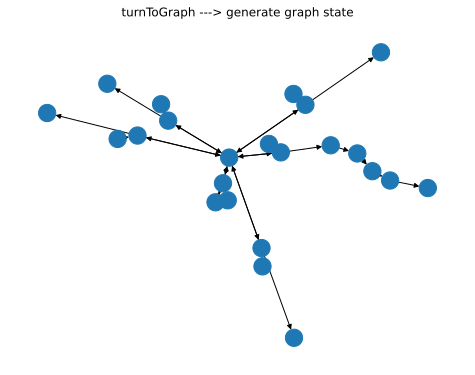

2.Node index: 1, Node attribute {'node_val': 'In', 'pos': (0, -1), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 2, Node attribute {'node_val': 'Aux', 'pos': (3, -1), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 3, Node attribute {'node_val': 'IO', 'pos': (6, 0), 'phase': -1, 'gate_name': 'CNOT'}
2.Node index: 4, Node attribute {'node_val': 'Out', 'pos': (9, -1), 'phase': -1, 'gate_name': 'CNOT'}
2.Node index: 5, Node attribute {'node_val': 'In', 'pos': (12, -2), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 6, Node attribute {'node_val': 'Aux', 'pos': (15, -2), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 7, Node attribute {'node_val': 'Out', 'pos': (18, -2), 'phase': -1, 'gate_name': 'CNOT'}
2.Node index: 8, Node attribute {'node_val': 'In', 'pos': (21, -3), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 9, Node attribute {'node_val': 'Aux', 'pos': (24, -3), 'phase': 0, 'gate_name': 'CNOT'}
2.Node index: 10, Node attribute {'node_val': 'Out', 'pos': (27, -3), 'phase': -1, 'gate

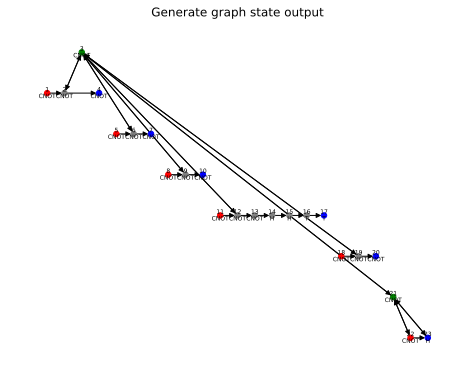

shift signal finished
-------------- 
Below is determine_dependency result


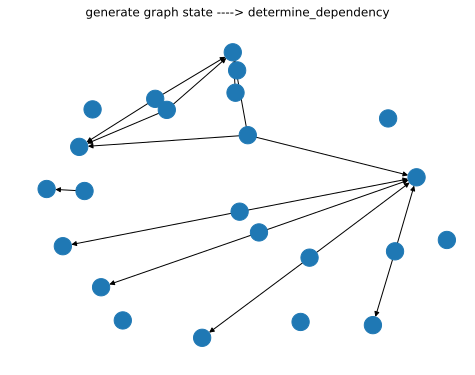

-------------- 
Below is undirected_graph result


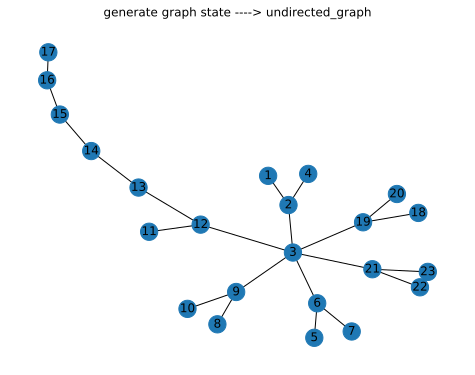

The depth [2, 2, 2, 3, 3, 4], Max degree, 6, Max length 9
Processing 2 degree nodes: [13, 14, 15, 16, 22, 23]
Current progress of Head nodes [14, 13]
Current progress of Head nodes [15, 14, 13]
Current progress of Head nodes [16, 15, 14, 13]
The path to be mapped, [16, 15, 14, 13]
The neighbours of the, 16, head node [15, 17]
The neighbours of the, 13, tail node [12, 14]
Head connectivity 1 , (AtlasView({16: {'con_qubits': {16: 2, 17: 1}}}), AtlasView({15: {'con_qubits': {15: 2, 16: 1}}, 17: {'con_qubits': {16: 2, 17: 1}}}))
Tail connectivity 3, {'con_qubits': {12: 3, 13: 1}}
The path: [16, 15, 14, 13]
Depths: [2, 2, 2, 3, 3, 4], Head connectivity: 1 
Head depths: 0
************************* 
Above was during 1 while loop
Processing 2 degree nodes: [22, 23]
Current progress of Head nodes [23, 22]
The path to be mapped, [23, 22]
The neighbours of the, 23, head node [21, 22]
The neighbours of the, 22, tail node [21, 23]


KeyError: 12

In [10]:
if __name__ == '__main__':
    ##############################################
    # 0. Visual representation in gate based model
    ##############################################
    print('---------------------- \nBelow is the gate version of the circuit of interest')
    import qiskit as qk
    q = qk.QuantumRegister(3)
   
    circuit = qk.QuantumCircuit(q)
    circuit.h(q[0])
    circuit.cx(q[0], q[1])
    circuit.cx(q[0], q[2])
    print (circuit)

    ############################################
    # 1. CUSTOM circuit that will be compiled 
    ############################################
    # Intialising circuit for PyZX
    nqubit = 4
    test_circuit = zx.Circuit(qubit_amount=nqubit)
    #test_circuit.add_gate("H", 0)
    #test_circuit.add_gate("CNOT", 0, 1)
    #test_circuit.add_gate("CNOT", 0, 2)
    #test_circuit.add_gate("CZ", 0, 3)
    #test_circuit.add_gate("H", 0 ,)
    #test_circuit.add_gate("H", 0 ,)
    #test_circuit.add_gate("T", 1)
    #test_circuit.add_gate("CNOT", 2, 3)
    #test_circuit.add_gate("CNOT", 1, 3)
    #test_circuit.add_gate("CZ", 0, 6)
    #test_circuit.add_gate("CNOT", 0, 3)
    
    ############################################
    # 1.1 Looking at the figure in paper
    ############################################
    nqubit = 8
    test_circuit = zx.Circuit(qubit_amount=nqubit)
    test_circuit.add_gate("CNOT", 0, 1)
    test_circuit.add_gate("CNOT", 0, 2)
    test_circuit.add_gate("CNOT", 0, 3)
    test_circuit.add_gate("CNOT", 0, 4)
    test_circuit.add_gate("H", 4 )
    test_circuit.add_gate("H", 4 )
    test_circuit.add_gate("T", 4 )
    test_circuit.add_gate("CNOT", 0, 5)
    test_circuit.add_gate("CZ", 6, 7) 
    test_circuit.add_gate("CZ", 0, 6)
    test_circuit.add_gate("H", 7 )
    test_circuit.add_gate("H", 4 )
    test_circuit.add_gate("T", 4 )
    test_circuit.add_gate("CZ", 6, 7)


    ############################################
    # 1.2 QASM circuit that will be compiled 
    ############################################
    #test_circuit = zx.Circuit.from_qasm_file('qasm_files/qf21_n15_transpiled_ori_modified.qasm')
    #test_circuit = zx.Circuit.from_qasm_file('qasm_files/debug_circuit_variational_n4_transpiled.qasmdebug_circuit_variational_n4_transpiled.qasm')
    
    ############################################
    # 1a. Adjustments to pyZX graph
    ############################################
    #zx.spider_simp(c)
    '''
    def to_rg(g):
    #"""Turns every red node into a green node by changing regular edges into hadamard edges"""
        ty = g.types()
        for v in g.vertices():
            if ty[v] == VertexType.Z:
                g.set_type(v, VertexType.X)
                for e in g.incident_edges(v):
                    et = g.edge_type(e)
                    g.set_edge_type(e, toggle_edge(et))
    '''
    #zx.to_gh(c)
    #zx.to_rg(c)
    #o_rg(c)
    #zx.draw(test_circuit)
    #zx.draw(c)

    ############################################
    # 2. Printing the pyZX
    ############################################
    print('---------------------- \nBelow is the pyZX plot of the circuit')
    c = test_circuit.to_graph()
    zx.draw(c)

    ############################################
    # 3. Converting to JCZ circuit object
    ############################################
    jcz_circuit = pyZX_to_JCZ(test_circuit,test_circuit.qubits)
    

    """
    ############################################
    # 3a. Manually adding to JCZ circuit object
    ############################################
    test_circuit.add_gate("ZPhase", 4, phase=0.75)
    jcz_circuit.add_J(4, phase=0.75)

    test_circuit.add_gate("X", 5)
    jcz_circuit.add_X(5)

    test_circuit.add_gate("Z", 6)
    jcz_circuit.add_Z(6)

    test_circuit.add_gate("S", 7)
    jcz_circuit.add_S(7)

    test_circuit.add_gate("RZ", 8, angle=2)
    jcz_circuit.add_Rz(8, phase=2)

    test_circuit.add_gate("CZ", 9,10)
    jcz_circuit.add_CZ(9,10)

    target_qubit = 11
    control_qubit = 12
    test_circuit.add_gate("H", target_qubit)
    test_circuit.add_gate("CNOT", control_qubit, target_qubit)
    test_circuit.add_gate("RZ", target_qubit, angle=2)
    test_circuit.add_gate("CNOT", control_qubit, target_qubit)
    test_circuit.add_gate("H", target_qubit)
    jcz_circuit.add_CRz(11,12,phase=2)
    """

    ############################################
    # 3. Adjustments to pyZX graph
    ############################################
    print( f"---------------------- \nBelow is the JCZ data (converted from circuit with {test_circuit.qubits} qubits) \n {jcz_circuit.gates}")
    #zx.draw(jcz_circuit)
    ############################################
    # 3. Adjustments to pyZX graph
    ############################################
    print('---------------------- \nNow executing the optimisation on the JCZ... \n \n')
    NxM = 3,3
    custom_main(jcz_circuit.gates, test_circuit.qubits, NxM , 50, prob=0.4)
    #zx.draw(test_circuit)


###########################################################
# MISC code, functions for to_rg and to_gh from source code
###########################################################
#from zx.utils import EdgeType, VertexType, toggle_edge, vertex_is_zx, toggle_vertex

'''
def to_gh(g: BaseGraph[VT,ET],quiet:bool=True) -> None:
    """Turns every red node into a green node by changing regular edges into hadamard edges"""
    ty = g.types()
    for v in g.vertices():
        if ty[v] == VertexType.X:
            g.set_type(v, VertexType.Z)
            for e in g.incident_edges(v):
                et = g.edge_type(e)
                g.set_edge_type(e, toggle_edge(et))

def to_rg(g: BaseGraph[VT,ET], select:Optional[Callable[[VT],bool]]=None) -> None:
    """Turn green nodes into red nodes by color-changing vertices which satisfy the predicate ``select``.
    By default, the predicate is set to greedily reducing the number of Hadamard-edges.
    :param g: A ZX-graph.
    :param select: A function taking in vertices and returning ``True`` or ``False``."""
    if select is None:
        select = lambda v: (
            len([e for e in g.incident_edges(v) if g.edge_type(e) == EdgeType.SIMPLE]) <
            len([e for e in g.incident_edges(v) if g.edge_type(e) == EdgeType.HADAMARD])
            )

    ty = g.types()
    for v in g.vertices():
        if select(v) and vertex_is_zx(ty[v]):
            g.set_type(v, toggle_vertex(ty[v]))
            for e in g.incident_edges(v):
                g.set_edge_type(e, toggle_edge(g.edge_type(e)))
'''


In [ ]:
from pyzx.routing import *

nqubit = 8
simple_circuit = zx.Circuit(qubit_amount=nqubit)
simple_circuit.add_gate("CNOT", 0, 1)
simple_circuit.add_gate("CNOT", 0, 2)
circuit_to_be_compiled = simple_circuit
architecture = create_architecture(name= "square", n_qubits=4)
 
#create_square_architecture()
compiled_circuit = route_phase_poly(
    circuit_to_be_compiled,
    architecture,
    method=RoutingMethod.GRAY_MEIJER,
    mode=ElimMode.STEINER_MODE,
    root_heuristic=RootHeuristic.RECURSIVE,
    split_heuristic=SplitHeuristic.COUNT)

print(compiled_circuit)


Circuit(4 qubits, 0 bits, 3 gates)
